# Introduction  

**What is Autogloun**  
AutoGluon is an open-source AutoML (Automated Machine Learning) library developed by Amazon Web Services (AWS). It enables developers and data scientists to quickly build accurate machine learning models

[**Website**](https://auto.gluon.ai/)  
[**GitHub**](https://github.com/autogluon/autogluon)

**Dataset info**  
Half-hourly UK electricity demand data (2009-2024) from [National Grid ESO] (https://www.neso.energy/), including national demand, renewable generation estimates, and interconnector flows.






# Setup: Libraries and Data

Install the AutoGluon library, import the required libraries, and load the dataset.



In [1]:
# Install the autogluon library
#!pip install -q autogluon

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter

In [4]:
# Load the data

df = pd.read_csv("UK_electricity_wind_2021_2024.csv")
df.head()

,settlement_date,england_wales_demand,is_holiday,item_id,embedded_wind_generation,embedded_wind_capacity
0,2021-01-01 00:00:00,26130.0,1,UK,1018,6527
1,2021-01-01 00:30:00,26281.0,1,UK,1026,6527
2,2021-01-01 01:00:00,25557.0,1,UK,1039,6527
3,2021-01-01 01:30:00,24792.0,1,UK,1052,6527
4,2021-01-01 02:00:00,23933.0,1,UK,1076,6527


# Data Processing and Visualization

We rename the target column, preview the data, plot the target, and assess its basic structure.

In [5]:
# set time stamp to_datetime
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df.dtypes


settlement_date             datetime64[ns]
england_wales_demand               float64
is_holiday                           int64
item_id                             object
embedded_wind_generation             int64
embedded_wind_capacity               int64
dtype: object

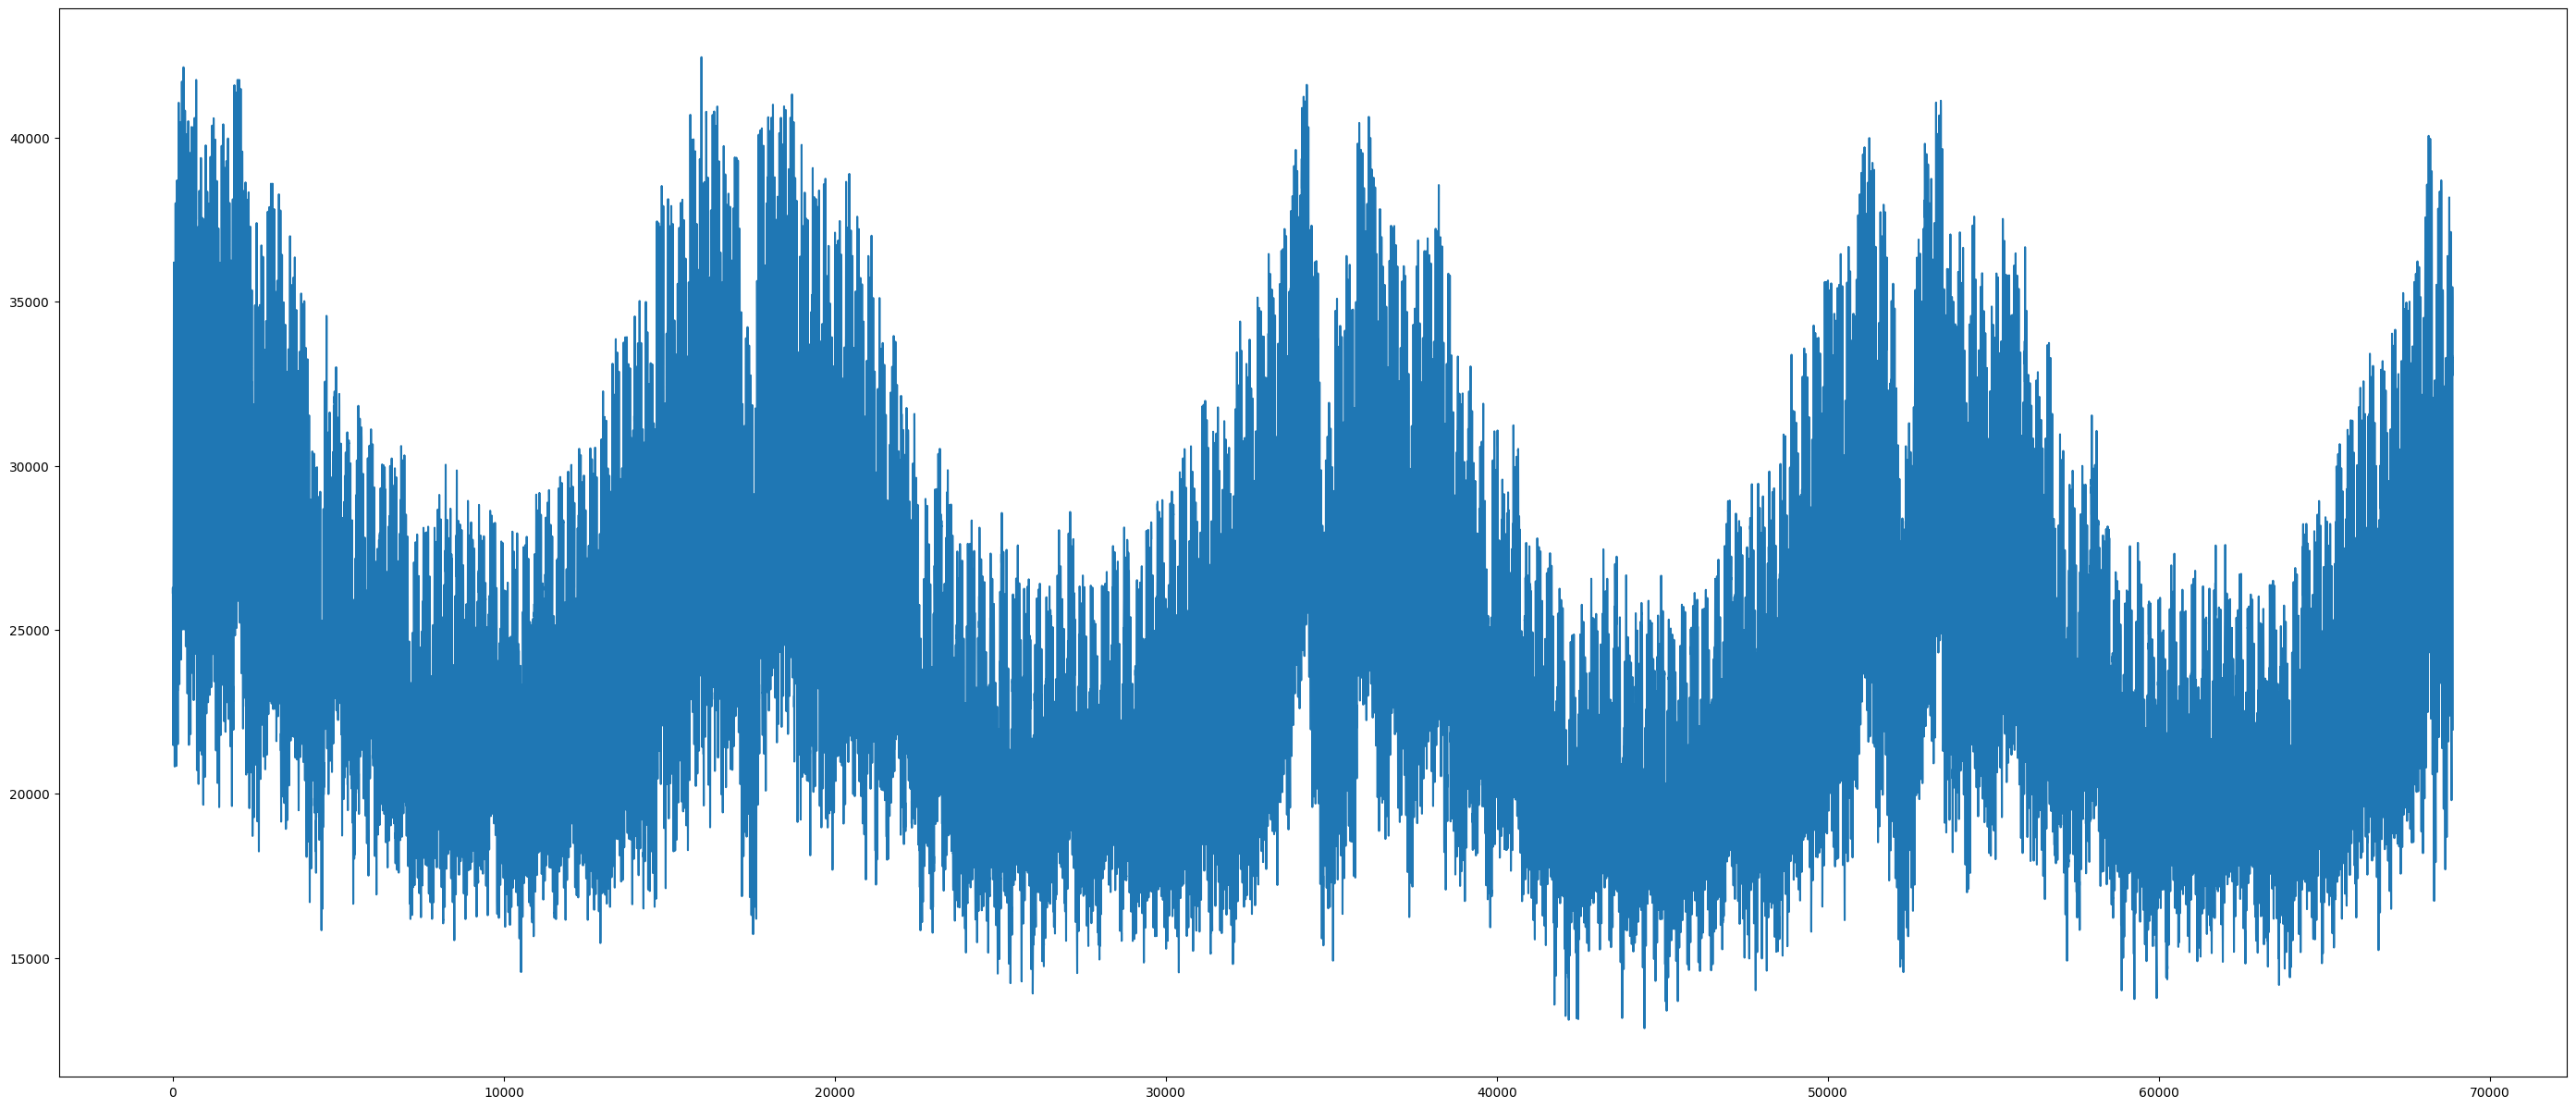

In [6]:
# Visualize the target variable over time
df.england_wales_demand.plot(figsize= (35,15))
plt.show()

In [7]:
# Rename the target variable "england_wales_demand" for easier referencing in our modeling steps
df.rename(columns={'england_wales_demand': 'y'}, inplace = True)
df.head()

,settlement_date,y,is_holiday,item_id,embedded_wind_generation,embedded_wind_capacity
0,2021-01-01 00:00:00,26130.0,1,UK,1018,6527
1,2021-01-01 00:30:00,26281.0,1,UK,1026,6527
2,2021-01-01 01:00:00,25557.0,1,UK,1039,6527
3,2021-01-01 01:30:00,24792.0,1,UK,1052,6527
4,2021-01-01 02:00:00,23933.0,1,UK,1076,6527


# Autogluon Model - Simple

We specify a prediction length and build a simple AutoGluon time-series model. 
We train it, list the models used, check the leaderboard, and generate predictions.

For a list of timeseries forecasting models trained by AutGluon see [here](https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-model-zoo.html)  
The portfolio is comprehensive of:  
- baseline models  
- statistical models  
- deep learning models  
- tabular models  
- pre-trained models 
  

## AutoGluon TimeSeriesDataFrame parameters

  

**id_column**:  
It just tells AutoGluon that all rows belong to one single time series.  
If the dataset has two locations (England and Wales) the time series has two groups. In this case we have only one.  

**static_features_df**   
it defines the attributes that are constant in the dataframe - attributes that do change between time series (eg. between England and Wales).   
For your UK dataset with a single series, static features aren't very useful since there's only one time series.

In [8]:
# Convert raw data into a TimeSeriesDataFrame

from autogluon.timeseries import TimeSeriesDataFrame

timeseries_df = TimeSeriesDataFrame.from_data_frame(
df,
id_column="item_id",
timestamp_column="settlement_date",
static_features_df=None)

timeseries_df

y  is_holiday  embedded_wind_generation  \
item_id timestamp                                                            
UK      2021-01-01 00:00:00  26130.0           1                      1018   
        2021-01-01 00:30:00  26281.0           1                      1026   
        2021-01-01 01:00:00  25557.0           1                      1039   
        2021-01-01 01:30:00  24792.0           1                      1052   
        2021-01-01 02:00:00  23933.0           1                      1076   
...                              ...         ...                       ...   
        2024-12-05 21:30:00  27212.0           0                      5377   
        2024-12-05 22:00:00  25477.0           0                      5486   
        2024-12-05 22:30:00  24428.0           0                      5594   
        2024-12-05 23:00:00  22590.0           0                      5575   
        2024-12-05 23:30:00  21958.0           0                      5556   

                             embedded_wind_capacity  
item_id timestamp                                    
UK      2021-01-01 00:00:00                    6527  
        2021-01-01 00:30:00                    6527  
        2021-01-01 01:00:00                    6527  
        2021-01-01 01:30:00                    6527  
        2021-01-01 02:00:00                    6527  
...                                             ...  
        2024-12-05 21:30:00                    6622  
        2024-12-05 22:00:00                    6622  
        2024-12-05 22:30:00                    6622  
        2024-12-05 23:00:00                    6622  
        2024-12-05 23:30:00                    6622  

[68872 rows x 4 columns]

In [9]:
# split the dataset in train and test

from sklearn.model_selection import train_test_split

train, test = train_test_split(timeseries_df, test_size=0.2)
len(train), len(test)

(55097, 13775)

In [10]:
# check train
train

y  is_holiday  embedded_wind_generation  \
item_id timestamp                                                            
UK      2024-01-21 19:30:00  30442.0           0                      5260   
        2023-04-27 09:30:00  28446.0           0                      1534   
        2021-03-19 20:30:00  30772.0           0                       434   
        2023-04-24 01:30:00  19197.0           0                      1927   
        2023-04-21 20:30:00  28071.0           0                      1458   
...                              ...         ...                       ...   
        2024-01-21 14:30:00  30261.0           0                      5087   
        2022-05-12 19:00:00  27108.0           0                      2896   
        2024-06-04 10:30:00  23340.0           0                      3429   
        2023-10-02 07:30:00  25231.0           0                       979   
        2022-10-26 20:30:00  26840.0           0                      2622   

                             embedded_wind_capacity  
item_id timestamp                                    
UK      2024-01-21 19:30:00                    6488  
        2023-04-27 09:30:00                    6545  
        2021-03-19 20:30:00                    6527  
        2023-04-24 01:30:00                    6545  
        2023-04-21 20:30:00                    6545  
...                                             ...  
        2024-01-21 14:30:00                    6488  
        2022-05-12 19:00:00                    6545  
        2024-06-04 10:30:00                    6562  
        2023-10-02 07:30:00                    6538  
        2022-10-26 20:30:00                    6545  

[55097 rows x 4 columns]

## Training

Create the model defining the parameters and train it to forecast the values

In [11]:
# predict one week ahead = (2*24)*7=336
prediction_length = 336

In [12]:
# Initialize the TimeSeriesPredictor with essential parameters
predictor = TimeSeriesPredictor(
    prediction_length = prediction_length,
    target = 'y',
    eval_metric = 'MAPE', 
    freq = "30min"

    )

### Model Parameters

**presets**  
Controls the number and complexity of models AutoGluon will train:

- `high_quality`: 12+ models (most thorough, slowest)
- `medium_quality`: 5–8 models (balanced)
- `low_quality`: fewer models (fastest, least accurate)

**num_val_windows**  
Number of validation windows used to evaluate model performance. Each window has the same length as `prediction_length` (in our case, 1 week). AutoGluon computes the evaluation metric (e.g., MAPE) on each window and averages the results.

Practical guidelines:
- 3 — quick iteration, good for initial experiments
- 5–10 — more robust evaluation, recommended for final models
- >10 — diminishing returns, significantly slower

**val_step_size**  
The offset (in time steps) between consecutive validation windows. With `val_step_size = 96` (2 days of 30-min intervals), each window starts 2 days before the previous one:

Note: Only the validation windows are used to compute metrics. All data *before* each window is used for training.

**random_seed**  
Fixes the random number generator to ensure reproducible results across runs.


In [13]:
# Train the model with specified presets, validation steps, and time limits
predictor.fit(
    train,
    presets = 'medium_quality',
    num_val_windows = 3, # 3 weeks
    val_step_size = 96, # the new windows starts 2 days before the previous window
    random_seed = 1502, 
    time_limit = 1200
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'c:\Users\fc\OneDrive - e-think energy research\CEU\Time series forecasting\python examples\class_demonstrations\AutogluonModels\ag-20260203_100119'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          0
Memory Avail:       6.96 GB / 14.83 GB (46.9%)
Disk Space Avail:   274.86 GB / 475.66 GB (57.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': '30min',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 336,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 1502,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'y',
 'time_limit'

In [14]:
# List the model_names
predictor.model_names()

['Naive',
 'SeasonalNaive',
 'RecursiveTabular',
 'DirectTabular',
 'ETS',
 'Theta',
 'Chronos[bolt_small]',
 'WeightedEnsemble']

## Monitoring

**leaderboard**:  
Normally, error metrics like RMSE, MASE, MAPE are "lower is better" — a smaller error means a better model. But AutoGluon standardizes all metrics to **"higher is better"**. This means that metrics such as MASE or MAPE will be multiplied by -1, so their values will be negative.  


Raw RMSE	AutoGluon score
3.27	-3.27
4.15	-4.15
So -3.27 is better than -4.15 because it's higher (closer to zero).

In [15]:
# Show performance (.leaderboard) of trained models
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.045270,4.494646,0.774659,8
1,Chronos[bolt_small],-0.048513,1.411476,9.302856,7
2,DirectTabular,-0.057093,0.997001,10.419325,4
3,RecursiveTabular,-0.116714,3.343070,13.451391,3
4,SeasonalNaive,-0.117017,2.211941,4.453362,2
5,Theta,-0.126159,1.639211,3.966687,6
6,ETS,-0.223127,3.169257,10.333118,5
7,Naive,-0.223129,2.086169,5.438376,1


## Prediction

In [16]:
# Generate predictions using the trained model
# it performs the model with the best prediction score (see leaderboard)

predictions = predictor.predict(timeseries_df, random_seed = 1502)
predictions.head()

data with frequency 'IRREG' has been resampled to frequency '30min'.


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean           0.1           0.2  \
item_id timestamp                                                       
UK      2024-12-06 00:00:00  22806.981315  21250.819026  21808.471231   
        2024-12-06 00:30:00  22641.341905  20570.050291  21318.211196   
        2024-12-06 01:00:00  22471.337522  20009.150723  20895.380793   
        2024-12-06 01:30:00  22149.902452  19401.724358  20366.077597   
        2024-12-06 02:00:00  21530.059549  18479.011226  19544.921638   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
UK      2024-12-06 00:00:00  22192.613350  22512.496447  22806.981315   
        2024-12-06 00:30:00  21828.348787  22258.773857  22641.341905   
        2024-12-06 01:00:00  21493.845334  22004.369259  22471.337522   
        2024-12-06 01:30:00  21057.825701  21623.474708  22149.902452   
        2024-12-06 02:00:00  20311.480560  20942.283918  21530.059549   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
UK      2024-12-06 00:00:00  23091.934933  23404.058265  23783.953313   
        2024-12-06 00:30:00  23028.286907  23439.974672  23947.503865   
        2024-12-06 01:00:00  22934.792112  23426.817015  24012.546203   
        2024-12-06 01:30:00  22674.868282  23247.311234  23905.937269   
        2024-12-06 02:00:00  22107.652562  22731.932482  23469.015819   

                                      0.9  
item_id timestamp                          
UK      2024-12-06 00:00:00  24319.764698  
        2024-12-06 00:30:00  24656.915746  
        2024-12-06 01:00:00  24833.712797  
        2024-12-06 01:30:00  24831.459453  
        2024-12-06 02:00:00  24492.070762

data with frequency 'IRREG' has been resampled to frequency '30min'.


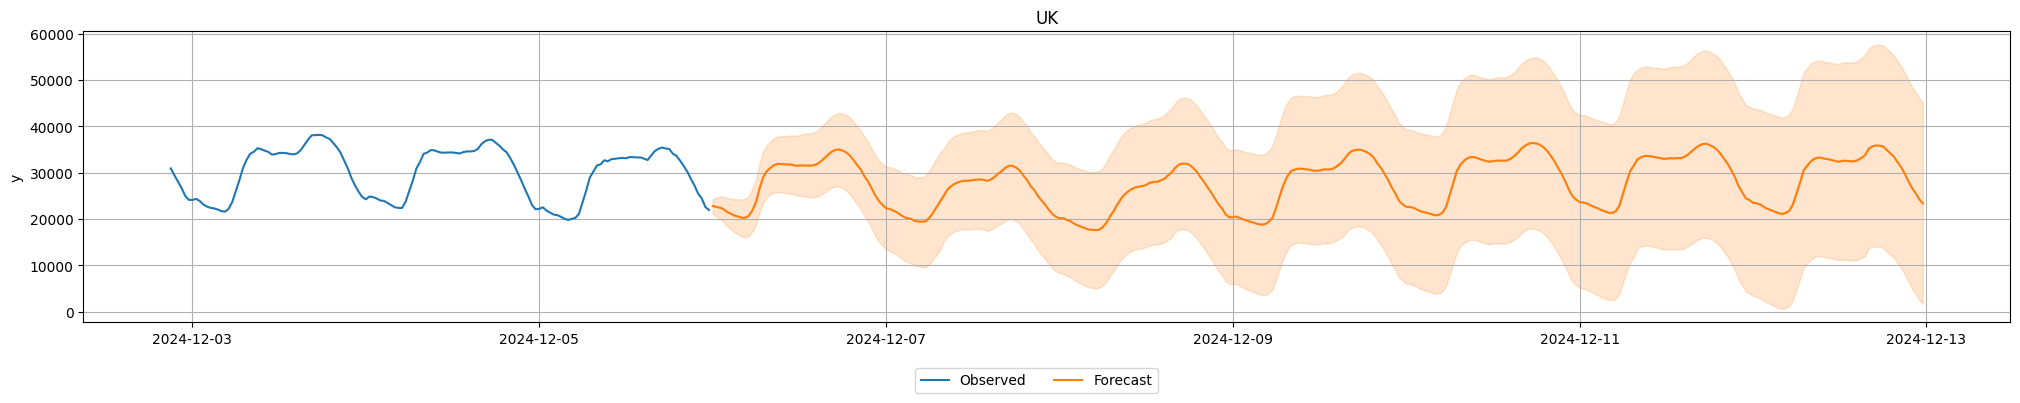

In [17]:
# Plot the actual time series (timeseries_df) along with the model predictions (predictions)
predictor.plot(timeseries_df, predictions, max_history_length=150);

We have a simple model trained on the data. The seasonality is more or less stable, but the CI becomes quite wide. 

# AutoGluon with Covariates

We load future covariates, convert them into the correct format, and retrain the model by including extra features like event days and day of week.


In [29]:
# Load future covariates to enrich the forecasting process
future_covariates = pd.read_csv("UK_electricity_solar_2021_2024.csv")
future_covariates.columns

Index(['settlement_date', 'england_wales_demand', 'item_id',
       'embedded_solar_generation', 'embedded_solar_capacity', 'is_holiday'],
      dtype='object')

In [30]:
# Convert the future covariates DataFrame into a TimeSeriesDataFrame
future_timeseries_df = TimeSeriesDataFrame.from_data_frame(
    future_covariates,
    id_column = 'item_id',
    timestamp_column = "settlement_date"
    )
future_timeseries_df

england_wales_demand  embedded_solar_generation  \
item_id timestamp                                                              
UK      2021-01-01 00:00:00               26130.0                          0   
        2021-01-01 00:30:00               26281.0                          0   
        2021-01-01 01:00:00               25557.0                          0   
        2021-01-01 01:30:00               24792.0                          0   
        2021-01-01 02:00:00               23933.0                          0   
...                                           ...                        ...   
        2024-12-05 21:30:00               27212.0                          0   
        2024-12-05 22:00:00               25477.0                          0   
        2024-12-05 22:30:00               24428.0                          0   
        2024-12-05 23:00:00               22590.0                          0   
        2024-12-05 23:30:00               21958.0                          0   

                             embedded_solar_capacity  is_holiday  
item_id timestamp                                                 
UK      2021-01-01 00:00:00                    13080           1  
        2021-01-01 00:30:00                    13080           1  
        2021-01-01 01:00:00                    13080           1  
        2021-01-01 01:30:00                    13080           1  
        2021-01-01 02:00:00                    13080           1  
...                                              ...         ...  
        2024-12-05 21:30:00                    17194           0  
        2024-12-05 22:00:00                    17194           0  
        2024-12-05 22:30:00                    17194           0  
        2024-12-05 23:00:00                    17194           0  
        2024-12-05 23:30:00                    17194           0  

[68872 rows x 4 columns]

## Training

In [37]:
#  Pass the whole dataset (timeseries_df, train, test) and  
# Initialize the TimeSeriesPredictor with known covariates
predictor2 = TimeSeriesPredictor(
    prediction_length = prediction_length,
    target = 'y',
    eval_metric = 'MAPE',
    freq = "30min",
    known_covariates_names = ["is_holiday"]
)

In [38]:
# Train the model using the covariates
predictor2.fit(
    train,
    presets = 'medium_quality',
    num_val_windows = 3, # 3 weeks
    val_step_size = 96, # the new windows starts 2 days before the previous window
    random_seed = 1502, 
    time_limit = 1200
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'c:\Users\fc\OneDrive - e-think energy research\CEU\Time series forecasting\python examples\class_demonstrations\AutogluonModels\ag-20260203_103143'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          0
Memory Avail:       3.76 GB / 14.83 GB (25.3%)
Disk Space Avail:   274.69 GB / 475.66 GB (57.7%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': '30min',
 'hyperparameters': 'light',
 'known_covariates_names': ['is_holiday'],
 'num_val_windows': 3,
 'prediction_length': 336,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 1502,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'y',
 

In [39]:
# Display the leaderboard for the new model
predictor2.leaderboard(silent = True)

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.045760,6.385303,1.643571,8
1,Chronos[bolt_small],-0.048513,1.757840,4.467497,7
2,DirectTabular,-0.059409,1.253097,13.297455,4
3,RecursiveTabular,-0.116714,5.504134,18.964164,3
4,SeasonalNaive,-0.117017,3.103990,6.852432,2
5,Theta,-0.126159,6.665781,7.384440,6
6,ETS,-0.223127,4.898495,14.156741,5
7,Naive,-0.223129,3.374367,8.651117,1


In [ ]:
# Generate predictions using known covariates
predictions2 = predictor2.predict(
    timeseries_df,
    random_seed = 1502,
    known_covariates = future_timeseries_df)
predictions2.head()

In [ ]:
# Plot the actual time series and predictions
predictor2.plot(timeseries_df, predictions2, max_history_length = 150);

We have now included extra features to boost the model's understanding of the data and refine the forecasts.

# Interpretability

We generate and visualize the feature importance to see which features have the biggest impact on the model's predictions.

In [ ]:
# Extract and store the feature importance metrics
feature_importance = predictor2.feature_importance(
    timeseries_df
)

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


In [ ]:
# Display the feature importance DataFrame
feature_importance

In [ ]:
# Plot the feature importance for a clear picture
feature_importance.importance.plot(kind = 'barh', figsize = (10, 6))
plt.title("Feature Importance with Autogluon")
plt.show();